# Clustering Crypto

In [5]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [2]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [6]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [143]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path)
crypto_df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [144]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply
crypto_df = crypto_df.iloc[:,1:9]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [145]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading']]
crypto_df.loc[crypto_df['IsTrading'] == False]

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply


In [146]:
# Keep only cryptocurrencies with a working algorithm
len(crypto_df['Algorithm'].unique())

89

In [147]:
#mask = crypto_trading['Algorithm'] != 'Multiple'
not_working_algo = ['Multiple', 'Counterparty', 'Momentum', 'Stanford Folding', '536', 'VeChainThor Authority', 'Green Protocol', 'Slatechain']
mask = crypto_df['Algorithm'].isin(not_working_algo)
crypto_df = crypto_df[~mask]
len(crypto_df['Algorithm'].unique())

81

In [148]:
# Remove the "IsTrading" column
crypto_df.drop(columns = 'IsTrading', inplace=True)

In [149]:
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365Coin,X11,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,PoW,NaN,611000
4,808,SHA-256,PoW/PoS,0.000000e+00,0


In [150]:
# Remove rows with at least 1 null value
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118 entries, 0 to 1247
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         1118 non-null   object 
 1   Algorithm        1118 non-null   object 
 2   ProofType        1118 non-null   object 
 3   TotalCoinsMined  668 non-null    float64
 4   TotalCoinSupply  1118 non-null   object 
dtypes: float64(1), object(4)
memory usage: 52.4+ KB


In [151]:
crypto_df.dropna(axis=0, how='any',inplace=True)
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 1247
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         668 non-null    object 
 1   Algorithm        668 non-null    object 
 2   ProofType        668 non-null    object 
 3   TotalCoinsMined  668 non-null    float64
 4   TotalCoinSupply  668 non-null    object 
dtypes: float64(1), object(4)
memory usage: 31.3+ KB


In [152]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined'] > 0.]

In [153]:
# Drop rows where there are 'N/A' text values
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
8,Ethereum,Ethash,PoW,1.076842e+08,0


In [154]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
CoinName_df = crypto_df.iloc[:,0:1]
CoinName_df.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
8,Ethereum


In [155]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_clean_df = crypto_df.drop(columns='CoinName')
crypto_clean_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0


In [156]:
# Create dummy variables for text features
crypto_clean_df = pd.get_dummies(crypto_clean_df)
crypto_clean_df.head()

,TotalCoinsMined,Algorithm_1GB AES Pattern Search,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,Algorithm_Cloverhash,Algorithm_CryptoNight,...,TotalCoinSupply_91388946,TotalCoinSupply_92000000000,TotalCoinSupply_9354000,TotalCoinSupply_9507271,TotalCoinSupply_9736000,TotalCoinSupply_98000000,TotalCoinSupply_98100000000,TotalCoinSupply_990000000000,TotalCoinSupply_999481516,TotalCoinSupply_9999999
0,4.199995e+01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.055185e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.927942e+10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.792718e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
# Standardize data

# Create the scaler instance
df_scaler = StandardScaler()

# Fit the scaler
df_scaler.fit(crypto_clean_df)

# Scale the features data
crypto_scaled = df_scaler.transform(crypto_clean_df)
crypto_scaled[0]

array([-0.11425994, -0.04397995, -0.04397995, -0.06225728, -0.07632328,
       -0.04397995, -0.06225728, -0.06225728, -0.04397995, -0.19513112,
       -0.06225728, -0.09872481, -0.04397995, -0.11704115, -0.07632328,
       -0.04397995, -0.04397995, -0.1539981 , -0.04397995, -0.13297266,
       -0.04397995, -0.08821622, -0.04397995, -0.04397995, -0.04397995,
       -0.04397995, -0.06225728, -0.04397995, -0.08821622, -0.08821622,
       -0.08821622, -0.04397995, -0.14030338, -0.14030338, -0.04397995,
       -0.06225728, -0.04397995, -0.07632328, -0.18420677, -0.04397995,
       -0.04397995, -0.04397995, -0.07632328, -0.16044493, -0.31957418,
       -0.04397995, -0.08821622, -0.07632328, -0.06225728,  1.35873244,
       -0.04397995, -0.04397995, -0.06225728, -0.04397995, -0.04397995,
       -0.04397995, -0.04397995, -0.04397995, -0.04397995, -0.40502462,
       -0.04397995, -0.18420677, -0.04397995, -0.08821622, -0.08821622,
       -0.10825318, -0.04397995, -0.13297266, -0.04397995, -0.04

### Reducing Dimensions Using PCA

In [158]:
# Use PCA to reduce dimensions to 3 principal components

# Initialize PCA model
pca = PCA(n_components=3)

# Get three principal components for the data.
crypto_pca = pca.fit_transform(crypto_scaled)

In [159]:
# Create a DataFrame with the principal components data
df_crypto_pca = pd.DataFrame(
    data=crypto_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_crypto_pca.head()

,principal component 1,principal component 2,principal component 3
0,-0.252496,-0.162444,-0.058561
1,-0.237278,-0.164748,-0.061968
2,0.276950,-0.128557,0.099262
3,-0.295940,-0.219271,-0.072146
4,-0.030059,-0.178895,-0.029443


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [160]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

C:\Tapas\Courses\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



:Curve   [k]   (inertia)

Running K-Means with `k = 4`

In [161]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(df_crypto_pca)

# Predict clusters
predictions = model.predict(df_crypto_pca)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
df_crypto_pca["clusters"] = model.labels_
df_crypto_pca.head()

,principal component 1,principal component 2,principal component 3,clusters
0,-0.252496,-0.162444,-0.058561,0
1,-0.237278,-0.164748,-0.061968,0
2,0.276950,-0.128557,0.099262,0
3,-0.295940,-0.219271,-0.072146,0
4,-0.030059,-0.178895,-0.029443,0


### Visualizing Results

#### 3D-Scatter with Clusters

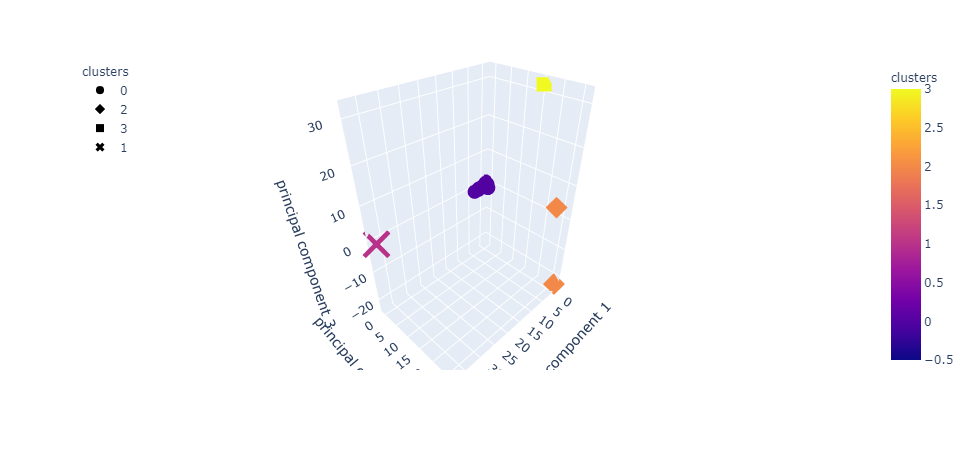

In [162]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    df_crypto_pca,
    x="principal component 1",
    y="principal component 2",
    z="principal component 3",
    color="clusters",
    symbol="clusters",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [176]:
# Table with tradable cryptos

# Converting 'TotalCoinSupply' datatype from object to numeric.
crypto_df['TotalCoinSupply'] = pd.to_numeric(crypto_df['TotalCoinSupply'])

crypto_df.loc[crypto_df['TotalCoinSupply'] > 0]

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07
...,...,...,...,...,...
1238,ZEPHYR,SHA-256,DPoS,2.000000e+09,2.000000e+09
1242,Gapcoin,Scrypt,PoW/PoS,1.493105e+07,2.500000e+08
1245,Beldex,CryptoNight,PoW,9.802226e+08,1.400223e+09
1246,Horizen,Equihash,PoW,7.296538e+06,2.100000e+07


In [181]:
# Print the total number of tradable cryptocurrencies
number_tradable_cryptos = crypto_df.loc[crypto_df['TotalCoinSupply'] > 0].count()
print(f"Total number of tradable crypto currencies: {number_tradable_cryptos[0]}")

Total number of tradable crypto currencies: 485


#### Scatter Plot with Tradable Cryptocurrencies

In [192]:
# Scale data to create the scatter plot
# Centered cols TotalCoinsMined and TotalCoinSupply with unit standard deviation
crypto_df['TotalCoinsMined'] = (crypto_df['TotalCoinsMined'] - crypto_df['TotalCoinsMined'].mean())/crypto_df['TotalCoinsMined'].std()
crypto_df['TotalCoinSupply'] = (crypto_df['TotalCoinSupply'] - crypto_df['TotalCoinSupply'].mean())/crypto_df['TotalCoinSupply'].std()
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,-0.114150,-0.149980
2,404Coin,Scrypt,PoW/PoS,-0.091306,-0.142217
5,EliteCoin,X13,PoW/PoS,0.519709,4.434426
7,Bitcoin,SHA-256,PoW,-0.113761,-0.149674
8,Ethereum,Ethash,PoW,-0.111818,-0.149980


(0, 5)

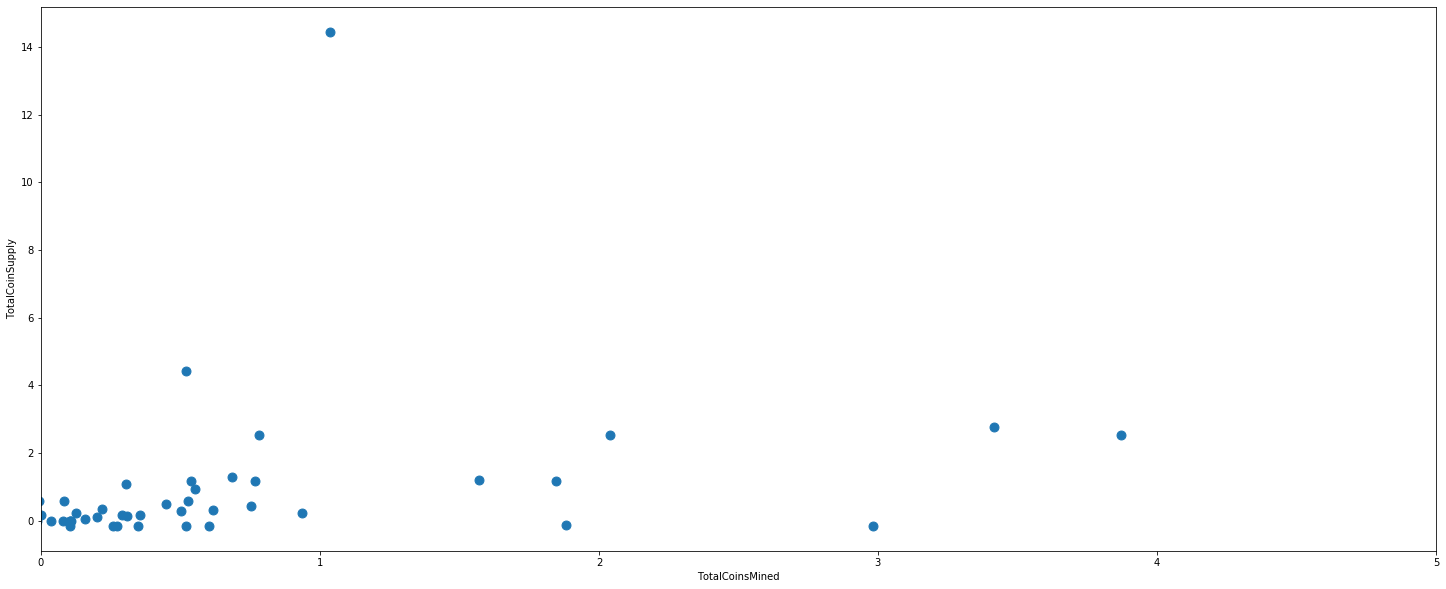

In [205]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
crypto_df.plot.scatter(x='TotalCoinsMined', y='TotalCoinSupply',s=80,figsize=(25,10))
plt.xlim(0, 5)